# New Test

In [167]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
from xhistogram.xarray import histogram
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
from flox.xarray import xarray_reduce

In [168]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff

This notebook is for binning the global argo dataset which includes all profiles that meet the following criteria:
- have salinity variable (others weeded out using my edits to the `to_xarray()` method in argopy)
- have at least 5 measurements (this is a requirement of argopy's `interp_std_levels()` method)
- have a max pressure greater than the min pressure (very small number of floats seemed to have unordered depths?)

The resulting dataset should have all the available data, including for profiles that don't reach 2000m. Argopy's `interp_std_levels()` method requires a profile has sampled to the maximum value in the interpolated depth grid, so when I was loading a box using `np.arange(0,2002,2)` only profiles that sampled to 2002m were being included. I've reworked my interpolation method to give `interp_std_levels()` a depth grid fitted to the max depth of that individual profile, then concatonated all of these profiles together (filing in nan values as necessary).

## Bin Data

In [169]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/new_test.nc', chunks={'N_PROF':10000})

In [170]:
ds = ds.assign_attrs({"Fetched_uri":''})
unique_prof = np.arange(len(ds['N_PROF']))
ds = ds.assign_coords(N_PROF=('N_PROF', unique_prof))
ds

<xarray.Dataset> Size: 123GB
Dimensions:            (PRES_INTERPOLATED: 1001, N_PROF: 2550896)
Coordinates:
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1996 1998 2000
    TIME               (N_PROF) datetime64[ns] 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    LATITUDE           (N_PROF) float64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    LONGITUDE          (N_PROF) float64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
  * N_PROF             (N_PROF) int64 20MB 0 1 2 3 ... 2550893 2550894 2550895
Data variables:
    CT                 (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    CYCLE_NUMBER       (N_PROF) int64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    DATA_MODE          (N_PROF) <U1 10MB dask.array<chunksize=(10000,), meta=np.ndarray>
    DIRECTION          (N_PROF) <U1 10MB dask.array<chunksize=(10000,), meta=np.ndarray>
    PLATFORM_NUMBER    (N_PROF) int64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    PRES               (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    SA                 (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

In [171]:
sample_max = 2.5

ds = ds.sortby('LATITUDE').persist()
boolean_indexer = (ds.sample_rate < sample_max).compute()
ds = ds.where(boolean_indexer, drop=True)

In [172]:
ds = ds.where(ds.LATITUDE>-67.5, drop=True).where(ds.LATITUDE<67.5, drop=True)

In [173]:
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-67.5,68,3)

In [174]:
def get_ds_binned(ds, lon_bins, lat_bins):
    
    ds_binned = xarray_reduce(
    ds,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)
    
    lon_l = np.arange(lon_bins[0],lon_bins[-1],3)
    lon_r = np.arange(lon_bins[1],lon_bins[-1]+1,3)
    lon_c = (lon_l + lon_r)/2

    lat_l = np.arange(lat_bins[0],lat_bins[-1],3)
    lat_r = np.arange(lat_bins[1],lat_bins[-1]+1,3)
    lat_c = (lat_l + lat_r)/2

    ds_binned = ds_binned.assign_coords({
        "lat_c": ("LATITUDE_bins", lat_c),
        "lat_l": ("LATITUDE_bins", lat_l),
        "lat_r": ("LATITUDE_bins", lat_r),
        "lon_c": ("LONGITUDE_bins", lon_c),
        "lon_l": ("LONGITUDE_bins", lon_l),
        "lon_r": ("LONGITUDE_bins", lon_r),
    })
    
    ds_binned = ds_binned.swap_dims({"LATITUDE_bins": "lat_c", "LONGITUDE_bins": "lon_c"})
    ds_binned = ds_binned.drop_vars(["LATITUDE_bins", "LONGITUDE_bins"])
    
    if isinstance(ds_binned, xr.Dataset):
        # For xarray.Dataset, use rename_dims and rename_vars
        ds_binned = ds_binned.rename_dims({"PRES_INTERPOLATED": "z_c"}).rename_vars({"PRES_INTERPOLATED": "z_c"})
    elif isinstance(ds_binned, xr.DataArray):
        # For xarray.DataArray, use rename to rename the dimension
        ds_binned = ds_binned.rename({"PRES_INTERPOLATED": "z_c"})
    else:
        raise TypeError("Input must be an xarray.Dataset or xarray.DataArray")

    
    return ds_binned

In [175]:
ds_binned = get_ds_binned(ds, lon_bins, lat_bins)

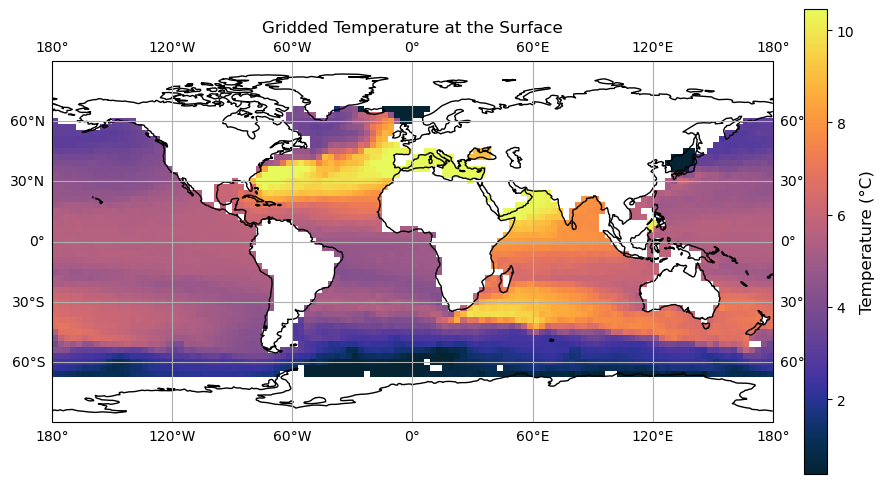

In [205]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

# Plot your data
plot = ds_binned.CT.isel(z_c=400).plot(
    ax=ax, x='lon_c', y='lat_c', cmap=cmo.thermal, add_colorbar=False, robust=True)

# Customize the colorbar
cbar = plt.colorbar(plot, ax=ax, fraction=0.03, pad=0.04)  # Adjust fraction for size
cbar.set_label('Temperature (°C)', fontsize=12)  # Set label and its font size

plt.ylim([-90, 90])
plt.title('Gridded Temperature at the Surface')
plt.show()

## Calculate Variance

### Open Diffusivities

In [178]:
ds_diff = xr.open_dataset('/swot/SUM05/amf2288/global_diff.nc')
K_rho = ds_diff.K
K_rho = K_rho.interp_like(ds_binned)

In [ ]:
K_rho

In [179]:
lfilt = 100

In [180]:
ct_b = ds.CT
sa_b = ds.SA
sp_b = ds.SPICE

ct_m = ff.ds_filt_single(ds, lfilt, 'CT')
sa_m = ff.ds_filt_single(ds, lfilt, 'SA')
sp_m = ff.ds_filt_single(ds, lfilt, 'SPICE')

ct_e = ct_b - ct_m
sa_e = sa_b - sa_m
sp_e = sp_b - sp_m

PROBLEM: this doesn't go up to 250 or down to 2000 because it's based on the centers :( Not entirely sure how to address this honestly

In [187]:
ct_2 = K_rho*get_ds_binned(ff.da_filt_single((ct_e.differentiate(coord='PRES_INTERPOLATED'))**2, lfilt), lon_bins, lat_bins)
sa_2 = K_rho*get_ds_binned(ff.da_filt_single((sa_e.differentiate(coord='PRES_INTERPOLATED'))**2, lfilt), lon_bins, lat_bins)
sp_2 = K_rho*get_ds_binned(ff.da_filt_single((sp_e.differentiate(coord='PRES_INTERPOLATED'))**2, lfilt), lon_bins, lat_bins)

ct_3 = K_rho*get_ds_binned((ct_m.differentiate(coord='PRES_INTERPOLATED'))**2, lon_bins, lat_bins)
sa_3 = K_rho*get_ds_binned((sa_m.differentiate(coord='PRES_INTERPOLATED'))**2, lon_bins, lat_bins)
sp_3 = K_rho*get_ds_binned((sp_m.differentiate(coord='PRES_INTERPOLATED'))**2, lon_bins, lat_bins)

In [188]:
ct_tot  = ct_2 + ct_3
ct_2rat = ct_2/ct_tot
ct_3rat = ct_3/ct_tot

sa_tot  = sa_2 + sa_3
sa_2rat = sa_2/sa_tot
sa_3rat = sa_3/sa_tot

sp_tot  = sp_2 + sp_3
sp_2rat = sp_2/sp_tot
sp_3rat = sp_3/sp_tot

In [189]:
ct_2rat

<xarray.DataArray (z_c: 1001, lon_c: 120, lat_c: 45)> Size: 43MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    z_l      (z_c) float64 8kB nan nan nan nan nan nan ... nan nan nan nan nan
    z_r      (z_c) float64 8kB nan nan nan nan nan nan ... nan nan nan nan nan
    lon_l    (lon_c) float64 960B -180.0 -177.0 -174.0 ... 171.0 174.0 177.0
    lon_r    (lon_c) float64 960B -177.0 -174.0 -171.0 ... 174.0 177.0 180.0
    lat_l    (lat_c) float64 360B -67.5 -64.5 -61.5 -58.5 ... 58.5 61.5 64.5
    lat_r    (lat_c) float64 360B -64.5 -61.5 -58.5 -55.5 ... 61.5 64.5 67.5
  * lat_c    (lat_c) float64 360B -66.0 -63.0 -60.0 -57.0 ... 60.0 63.0 66.0
  * z_c      (z_c) int64 8kB 0 2 4 6 8 10 12 ... 1990 1992 1994 1996 1998 2000
  * lon_c    (lon_c) float64 960B -178.5 -175.5 -172.5 ... 172.5 175.5 178.5

Text(0.5, 1.0, 'Gridded Temperature at 400m')

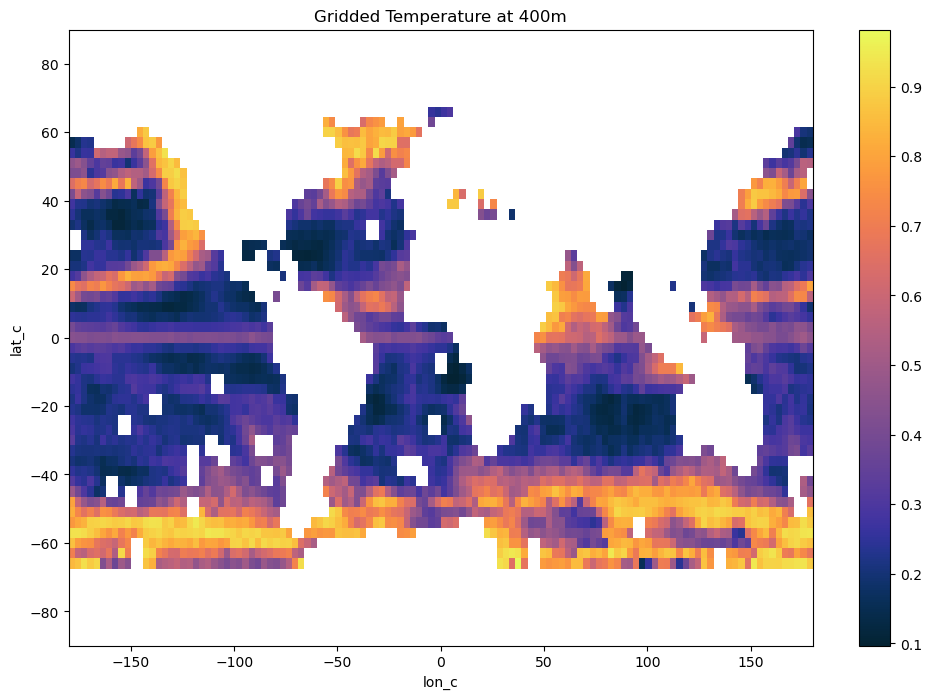

In [190]:
plt.figure(figsize=(12,8))
sp_2rat.sel(z_c=400, method='nearest').plot(x='lon_c',y='lat_c',cmap=cmo.thermal)
plt.ylim([-90,90])
plt.title(f"Gridded Temperature at {depth}m")